In [ ]:
"""
This notebook is used to finely register (map) a reference wing to the live bee wings using
the coarse registration from the last step as a starting point, and using ORB registration algorithm

It works OKAY, but required an annoying amount of fine-tuning for many of the images.
In retrospect, I should have just used the images that were good enough from the coarse 
registration, and applied SAM to those, then trained the UNet model on that and skipped this notebook entirely.
"""

In [1]:
# Now that we have a coarse grained registration using the segmentations we can do a fine
# grained registration to our type segmentation using skimage
import os
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm

from utils import place_in_img

  0%|                                                                                                                                                          | 0/1193 [00:00<?, ?it/s]


{'registration_ref': '../2_live_bees/type_mask_Hive01_Sheet_01_slide17_left.png',
 'registration_pos': [1890, 320],
 'registration_angle': -22.59206640479991,
 'registration_scale': 1.967475960389767,
 'registration_score': 0.9268111541658847,
 'is_facing_up?': True,
 'wing_side': 'right',
 'crop_y': [1616, 2269],
 'crop_x': [56, 1091]}

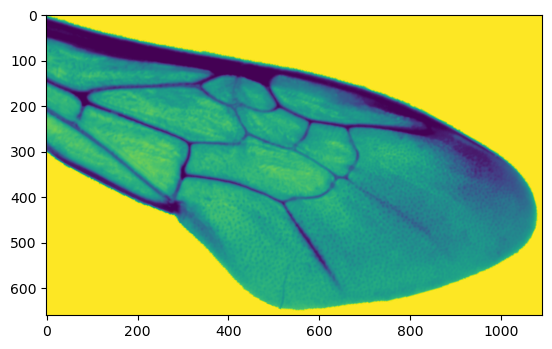

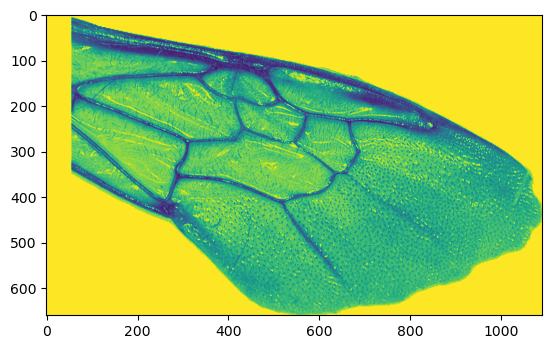

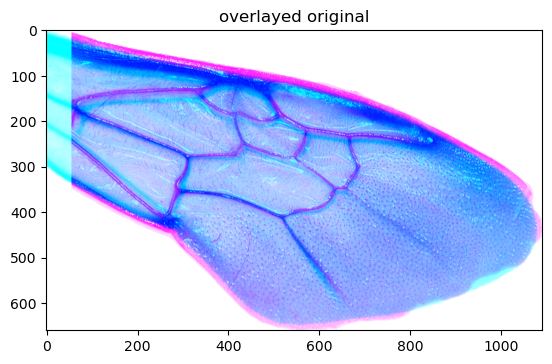

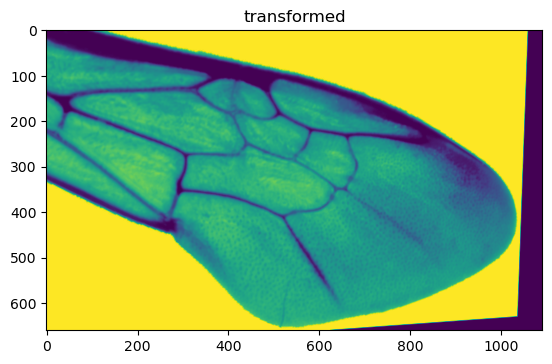

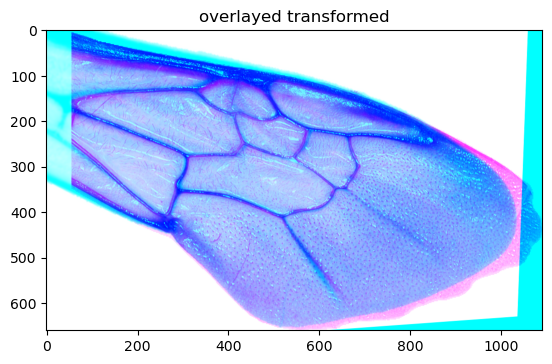

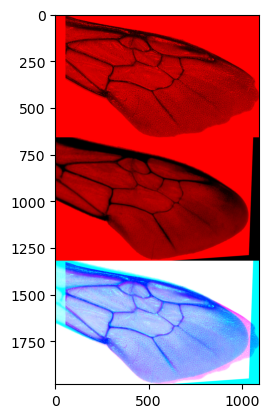

In [2]:
DEBUG = True
mask_metadata_fps = sorted(glob('../2_live_bees/3_card_mask_matches_metadata/*'))
np.random.shuffle(mask_metadata_fps)
for mask_metadata_fp in tqdm(mask_metadata_fps):
    
    reference_seg = cv2.imread('../2_live_bees/type_seg_Hive01_Sheet_01_slide17_left.png')
    fn = mask_metadata_fp.split('/')[-1]
    if os.path.exists('../2_live_bees/4_segs/'+fn.replace('.json','.png')) and not DEBUG:
        continue
    
    with open(mask_metadata_fp, 'r') as f:
        metadata = json.load(f)

    
    ref_pos = metadata['registration_pos']
    ref_pos[0] = ref_pos[0]#  - metadata['crop_y'][0] # change the reference to be from the top of the segmentation mask
    
    ref_scale = metadata['registration_scale']
    ref_angle = metadata['registration_angle']
    
    is_facing_up = metadata['is_facing_up?']
    
    
    mask_fp = '../2_live_bees/2_final_masks/' + fn.replace('.json','.png')
    seg_fp = '../2_live_bees/2_card_segs/' + fn.replace('.json','.png')
    
    mask = cv2.imread(mask_fp, cv2.IMREAD_GRAYSCALE)
    seg = cv2.imread(seg_fp)

    if not is_facing_up:
        mask = np.flipud(mask)
        seg = np.flipud(seg)
    
    img = np.ones(seg.shape)*255
    gray_ref = cv2.cvtColor(place_in_img(img, reference_seg, ref_pos, ref_scale, ref_angle, fill=255), cv2.COLOR_BGR2GRAY)
    gray_seg = cv2.cvtColor(seg, cv2.COLOR_BGR2GRAY)

    sy, sx = np.array(np.where((gray_ref.astype('float') + gray_seg.astype('float')) < 500)).min(axis=1)
    ey, ex = np.array(np.where((gray_ref.astype('float') + gray_seg.astype('float')) < 500)).max(axis=1)
    gray_ref = gray_ref[sy:ey, sx:ex]
    gray_seg = gray_seg[sy:ey, sx:ex]

    
    height, width = gray_seg.shape
    plt.figure()
    plt.imshow(gray_ref)
    plt.figure()
    plt.imshow(gray_seg)
    
    
    # Create ORB detector with 5000 features.
    orb_detector = cv2.ORB_create(10000)

    
    
    # Find keypoints and descriptors.
    # The first arg is the image, second arg is the mask
    #  (which is not required in this case).
    kp1, d1 = orb_detector.detectAndCompute(gray_ref, None)
    kp2, d2 = orb_detector.detectAndCompute(gray_seg, None)
    
    # Match features between the two images.
    # We create a Brute Force matcher with 
    # Hamming distance as measurement mode.
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

    # Match the two sets of descriptors.
    matches = list(matcher.match(d1, d2))
    
    # Sort matches on the basis of their Hamming distance.
    matches.sort(key = lambda x: x.distance)
    
    # Take the top 90 % matches forward.
    matches = matches[:int(len(matches)*0.9)]
    no_of_matches = len(matches)
    
    # Define empty matrices of shape no_of_matches * 2.
    p1 = np.zeros((no_of_matches, 2))
    p2 = np.zeros((no_of_matches, 2))
    
    for i in range(len(matches)):
      p1[i, :] = kp1[matches[i].queryIdx].pt
      p2[i, :] = kp2[matches[i].trainIdx].pt
    
    # Find the homography matrix.
    homography, mask = cv2.findHomography(p1, p2, cv2.RANSAC)
    
    # Use this matrix to transform the
    # colored image wrt the reference image.
    transformed_img = cv2.warpPerspective(gray_ref,
                        homography, (width, height))
    
    
    
    img = np.ones((gray_seg.shape[0], gray_seg.shape[1], 3))*255
    img[:,:,0] = gray_ref
    img[:,:,1] = gray_seg
    img = img.astype('uint8')
    plt.figure()
    plt.imshow(img)
    plt.title('overlayed original')


    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sy, sx = np.array(np.where(gray_img < 240)).min(axis=1)
    ey, ex = np.array(np.where(gray_img < 240)).max(axis=1)
    img = img[sy:ey, sx:ex]
    
    


 

    im = np.ones((gray_seg.shape[0], gray_seg.shape[1], 3))*255
    im[:,:,0] = transformed_img
    im[:,:,1] = gray_seg
    plt.figure()
    plt.imshow(transformed_img)
    plt.title('transformed')
    plt.figure()
    plt.imshow(im.astype('uint8'))
    plt.title('overlayed transformed')

    out = np.zeros((gray_seg.shape[0]*3,gray_seg.shape[1], 3))
    out[:gray_seg.shape[0],:,0] = gray_seg
    out[gray_seg.shape[0]:gray_seg.shape[0]*2,:,0] = transformed_img
    out[gray_seg.shape[0]*2:,:] = im
    plt.figure()
    plt.imshow(out.astype('uint8'))
    if DEBUG:
        break
metadata

In [61]:
plt.imshow()

TypeError: imshow() missing 1 required positional argument: 'X'

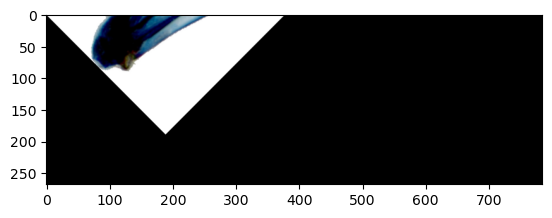

In [10]:
center = (reference_seg.shape[1]//2, reference_seg.shape[0]//2)
angle = -50
scale = 0.6
 
 
 
rot_mat = cv2.getRotationMatrix2D( (0,0), 45, 1 )
 
 
 
warp_rotate_dst = cv2.warpAffine(reference_seg, rot_mat, (reference_seg.shape[1], reference_seg.shape[0]))
plt.imshow(warp_rotate_dst)